# Import

In [1]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.colors as colors

In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Data structure

In [3]:
data_set = [{'Rl': 40, 'N': 64, 'files_matrix' : 200, 'ite_spec' : 200, 'filter_k' : 12},
        {'Rl': 60, 'N': 128, 'files_matrix' : 56786, 'ite_spec' : 40000, 'filter_k' : 12},
        {'Rl': 90, 'N': 256, 'files_matrix' : 10858, 'ite_spec' : 10000, 'filter_k' : 25},
        {'Rl': 160, 'N': 512, 'files_matrix' : 222, 'ite_spec' : 200, 'filter_k' : 40},
        {'Rl': 250, 'N': 1024, 'files_matrix' : 156, 'ite_spec' : 1200, 'filter_k' : 80}]

# Reading files

In [4]:
def read_matrix_file(Rl, N, run_files) :
    folder='/home/gorbunov8a/data/shell_to_shell/Rl' + str(Rl) + '_N' + str(N) + "/run1/" 
    file_type = "shell_to_shell_transfer_positive_part_ite="
    file = folder + file_type + "%06d" % run_files + ".table"
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    k = np.array(file_data[0])
    nb_of_modes = np.array(file_data[1])
    T_pos = np.array(file_data[2:])
    del file_data

    file_type = "shell_to_shell_transfer_negative_part_ite="
    file = folder + file_type + "%06d" % run_files + ".table"
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    k = np.array(file_data[0])
    nb_of_modes = np.array(file_data[1])
    T_neg = np.array(file_data[2:])
    return [k, nb_of_modes, T_pos, T_neg]

In [5]:
def read_spec_file(Rl, N, run_files) :
    folder='/home/gorbunov8a/data/shell_to_shell/Rl' + str(Rl) + '_N' + str(N) + "/run1/" 
    file_type = "vel_spec_kstar_ite="
    file = folder + file_type + "%06d" % run_files + ".table"
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    spec_table = np.array(file_data)
    # k = spec_table[:,0]
    # nb_of_modes = spec_table[:,1]
    Ek = spec_table[:,2]
    return Ek

In [6]:
# read data files
for simu in data_set : 
    Rl = simu['Rl']; N = simu['N']
    [k, nb_of_modes, T_pos, T_neg] = read_matrix_file(Rl, N, simu['files_matrix']) 
    #Ek = read_spec_file(Rl, N, simu['ite_spec']) 
    Ek = 0
    T = T_pos + T_neg
    simu.update({'k': k, 'nb_of_modes' : nb_of_modes, 'T_neg' : T_neg, 'T_pos' : T_pos, 'T' : T, 'Ek' : Ek})
    del k, nb_of_modes, T_pos, T_neg, Ek

# Parameters

In [7]:
# PARAMETERS
nu = 0.0001
pi = np.pi
for simu in data_set : 
    if (simu['Rl'] == 40) :
        simu['lambda'] = 0.57; simu['eta'] = 0.511e-1; simu['dissip_rate'] = 0.145e-6; 
        simu['ekin'] = 5.34e-5;
    if (simu['Rl'] == 60) :
        simu['lambda'] = 0.378; simu['eta'] = 0.0254807; simu['dissip_rate'] = 0.2244E-5
        simu['ekin'] = 3.53e-4;  
    if (simu['Rl'] == 90) :
        simu['lambda'] = 0.2352; simu['eta'] = 0.126e-1; simu['dissip_rate'] = 0.3919e-4;
        simu['ekin'] = 2.25e-3; 
    if (simu['Rl'] == 160) :
        simu['lambda'] = 0.155; simu['eta'] = 0.006436; simu['dissip_rate'] = 0.6E-3; 
        simu['ekin'] = 1.59e-2; 
    if (simu['Rl'] == 250) :
        simu['lambda'] = 0.1; simu['eta'] = 0.32e-2; simu['dissip_rate'] = 0.94e-2;
        simu['ekin'] = 0.1013; 
    #simu['t0']=simu['dissip_rate']**(-1.0/3.0)*simu['L']**(2.0/3.0) #large scale eddy-turnover time characteristic scale 
    simu['urms'] = np.sqrt(2.0/3.0*simu['ekin']); simu['L'] = np.sqrt(2.0/3.0*simu['ekin'])**3/simu['dissip_rate'] 
    simu['t0'] = simu['L']/simu['urms']
    simu['k_norm'] = 1/(2.0*np.pi/simu['L']) # integral scale as non-dimensionalisation factor
    simu['spatial_scales'] = np.array([simu['L'], simu['lambda'], simu['eta']])
    simu['spher_coef'] = 4.0*np.pi*simu['k']**2.0/simu['nb_of_modes']
    simu['norm_coef'] = 1.0/np.max([np.max(np.abs(simu['T_neg'])), np.max(np.abs(simu['T_pos']))])

# Plot appereance

In [8]:
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=11)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
linestyles = [(0, (5, 10)), '-', '--', ':', (0, (3, 5, 1, 5, 1, 5)), '-.']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

In [9]:
for simu in data_set :
    simu['legend'] = r"$R_{\lambda}=$" + str(simu['Rl']) + r"$, N = $" + str(simu['N'])
    simu['legend_short'] = r"$R_{\lambda}=$" + str(simu['Rl'])

# Energy spectrum

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """


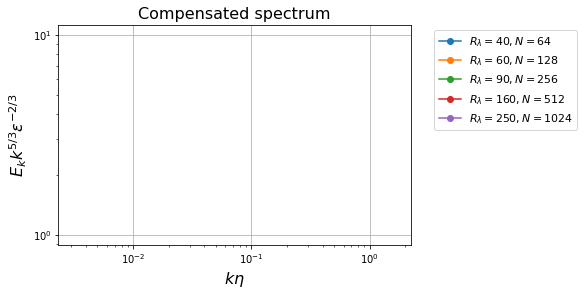

In [10]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))

for simu in data_set :
    ax.plot(simu['k']*simu['eta'], simu['Ek']*simu['k']**(5.0/3.0)*simu['dissip_rate']**(-2.0/3.0), '-o', label = simu['legend'])
ax.set(xscale='log', yscale='log', xlabel=r'$k \eta$', ylabel=r'$E_k k^{5/3} \epsilon^{-2/3}$', title='Compensated spectrum'); ax.grid()

# vertical_lines=wn_scales
# for line in vertical_lines : ax.axvline(x=line)
# ax2 = ax.twiny()
# ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
# ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Dissipation spectrum

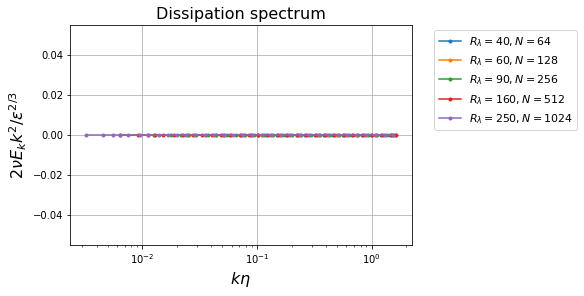

In [11]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))

for simu in data_set :
    simu['D'] = 2.0*nu*simu['Ek']*(simu['k']**2.0)
    ax.plot(simu['k']*simu['eta'], simu['D']*simu['eta']**(2.0)*(nu**5.0*simu['dissip_rate'])**(-1.0/4.0), '.-', label = simu['legend'])
ax.set(xscale='log', yscale='linear', xlabel=r'$k \eta$', ylabel=r'$ 2 \nu E_k k^{2} / \epsilon^{2/3}$', title='Dissipation spectrum'); ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Energy transfer spectrum

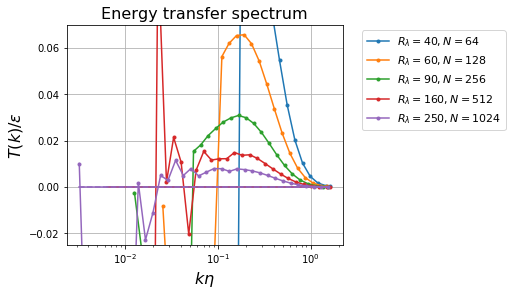

In [12]:
fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)

for i in range(len(data_set)) :
    simu=data_set[i]
    simu['total_transfer'] = 0.5*(np.sum(simu['T'], axis=0) - np.sum(simu['T'], axis=1))*simu['spher_coef'] 
    ax.plot(simu['k']*simu['eta'], simu['total_transfer']/simu['dissip_rate'], '.-', label = simu['legend'])
    ax.plot(simu['k']*simu['eta'], simu['D']/simu['dissip_rate'], '--', color=colors[i])
    ax.plot(simu['k']*simu['eta'], np.full_like(simu['k'], np.sum(simu['T'])), '-', color=colors[i])
ax.set(xscale='log', yscale='linear', xlabel=r'$k \eta$', ylabel=r'$ T(k) / \epsilon$', title='Energy transfer spectrum'); ax.grid()
ax.set(ylim=[-0.025,0.07])
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Energy flux

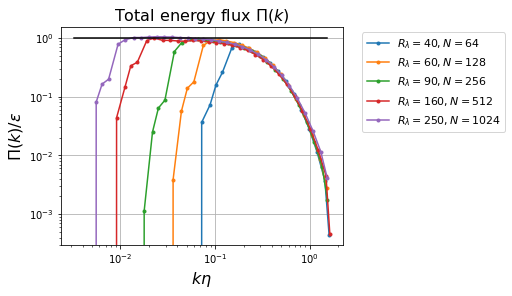

In [13]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(7,4))
for simu in data_set :
    simu['flux'] = np.zeros(shape=simu['k'].shape[0], dtype=float) 
    for ik in list(range(simu['k'].shape[0])) :
        simu['flux'][ik] = -np.sum(simu['T'][ik:, :ik])
    ax.plot(simu['k']*simu['eta'], simu['flux']/simu['dissip_rate'], '.-', label = simu['legend'])
ax.plot(simu['k']*simu['eta'], np.full_like(simu['k'], 1.0), 'k-')
ax.set(xlabel=r'$k \eta$', ylabel=r'$\Pi(k)/\epsilon$', title=r'Total energy flux $\Pi(k)$'); ax.grid()
ax.set(xscale='log', yscale='log')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot shell-to-shell energy transfer matrix

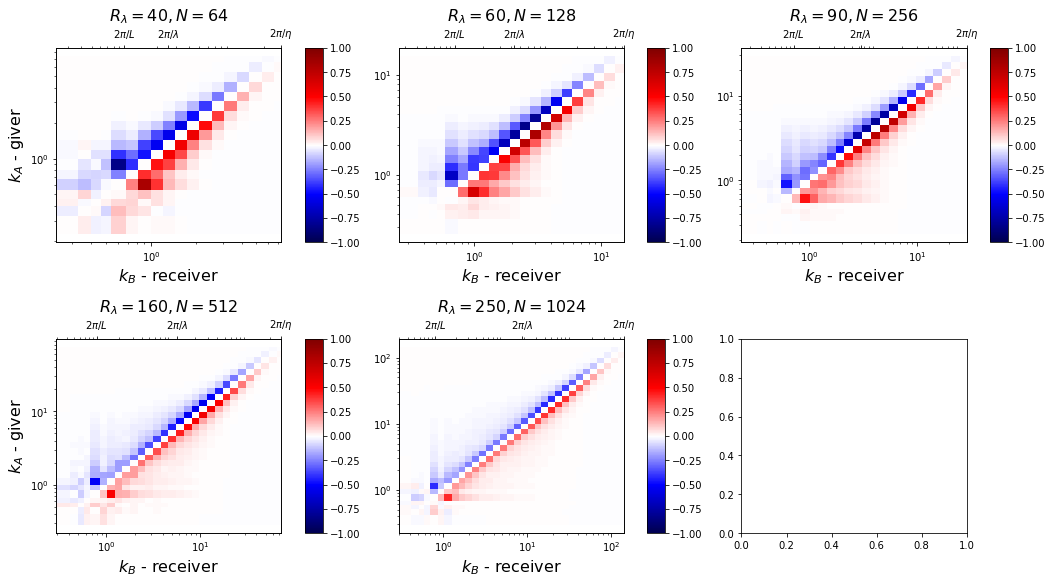

In [21]:
nb_of_rows = 2
nb_of_columns = 3
table = np.arange(len(data_set)+1).reshape(nb_of_rows,nb_of_columns)

fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_columns, constrained_layout=True,figsize=(3.5*nb_of_columns+4,4*nb_of_rows))
#fig.suptitle(r'Shell-to-shell Energy Transfer', size=14) 
for index, isimu in np.ndenumerate(table):
    if isimu<len(data_set) :
        simu = data_set[isimu]
        im = ax[index].pcolormesh(simu['k']*simu['k_norm'], simu['k']*simu['k_norm'], simu['T'] * simu['norm_coef'], cmap='seismic', vmin=-1.0, vmax=1.0)
        #ax[index].set_aspect('equal', 'datalim')
        ax[index].set(xlabel=r'$k_B$ - receiver', xscale='log', yscale='log', title=simu['legend'])
        if (index[1]==0) : ax[index].set(ylabel=r'$k_A$ - giver')
        ax2 = ax[index].twiny()
        ax2.set(xscale='log', yscale='log', xlim = ax[index].get_xlim())
        vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
        ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
        fig.colorbar(im, ax=ax[index])

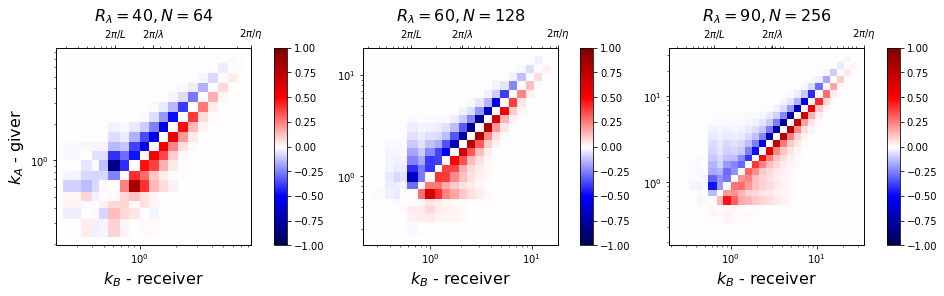

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(3*3+4,4))
#fig.suptitle(r'Shell-to-shell Energy Transfer', size=14) 
for index in range(3):
    simu = data_set[index]
    im = ax[index].pcolormesh(simu['k']*simu['k_norm'], simu['k']*simu['k_norm'], simu['T'] * simu['norm_coef'], cmap='seismic', vmin=-1.0, vmax=1.0)
    ax[index].set_aspect('equal', 'datalim')
    ax[index].set(xlabel=r'$k_B$ - receiver', xscale='log', yscale='log', title=simu['legend'])
    if (index==0) : ax[index].set(ylabel=r'$k_A$ - giver')
    ax2 = ax[index].twiny()
    ax2.set(xscale='log', yscale='log', xlim = ax[index].get_xlim())
    vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    fig.colorbar(im, ax=ax[index],aspect=50)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/shellToShell1.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

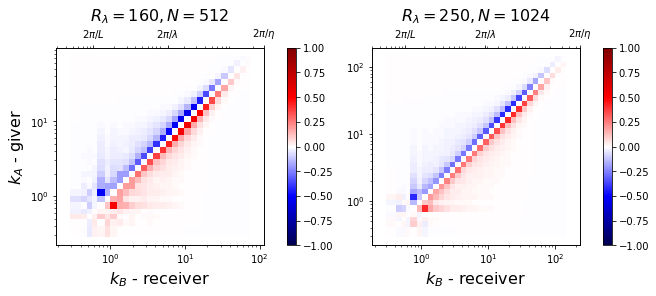

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(3*2+3,4),squeeze=True)
#fig.suptitle(r'Shell-to-shell Energy Transfer', size=14) 
for index in range(2) :
    simu = data_set[index+3]
    im = ax[index].pcolormesh(simu['k']*simu['k_norm'], simu['k']*simu['k_norm'], simu['T'] * simu['norm_coef'], cmap='seismic', vmin=-1.0, vmax=1.0)
    ax[index].set_aspect('equal', 'datalim')
    ax[index].set(xlabel=r'$k_B$ - receiver', xscale='log', yscale='log', title=simu['legend'])
    if (index==0) : ax[index].set(ylabel=r'$k_A$ - giver')
    ax2 = ax[index].twiny()
    ax2.set(xscale='log', yscale='log', xlim = ax[index].get_xlim())
    vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    fig.colorbar(im, ax=ax[index],aspect=50)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/shellToShell2.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

## Forcing band

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


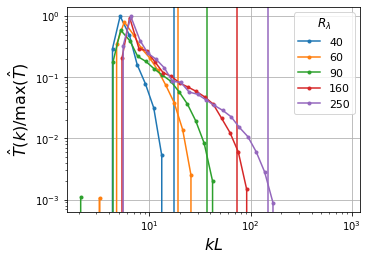

In [54]:
fig, ax = plt.subplots(figsize=(5,3.5),constrained_layout=True)
ikf = 4

for i in range(len(data_set[0::])) :
    simu=data_set[i]
    ax.plot(simu['k'][1::]*simu['L']**1, simu['T'][ikf, 1:]/np.max(abs(simu['T'])), '.-', label = simu['Rl'])
    ax.plot(simu['k']*simu['L'], simu['D']/max(simu['D']), '--',color=colors[i])
    ax.axvline(x=simu['filter_k']*simu['L'], color=colors[i])
ax.set(xlabel=r'$kL$', ylabel=r'$\hat{T}(k)/ \max(\hat{T})$'); ax.grid()
ax.set(xscale='log', yscale='log')
#ax.set(xlim=[0,1100])
lgd = ax.legend(loc='best', title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/forcingTransfer.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

In [16]:
for simu in data_set :
    print(simu['filter_k']*simu['lambda'])

6.84
4.536
5.88
6.2
8.0


In [17]:
for simu in data_set :
    print(simu['filter_k'])

12
12
25
40
80
